# Multilayer composition

After generating some thresholded networks, we will explore how they look like and whether there is a difference in basic structure between them. We will answer two main questions and a bonus:
1. Is there a difference between groups in terms of interlayer or intralayer degrees?
2. How multiplex-y are the networks?
3. Bonus: Is there a difference between groups in terms of interlayer or intralayer strength?

### A quick recap
We will use Model 1 for the analysis (subjects are layers, ROIs are nodes).
We have 36 patients and 29 controls.
We have 14 ROIs
We used a full-weighted supra-adjacency matrices where corr>0.
FC, ISC, and ISFC are all computed from the same nii file (movie watching). Ideally, we would have rs-fMRI for FC.

In [117]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import random
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

sys.path.insert(0, '/m/cs/scratch/networks/trianaa1/Paper2/Multilayer-networks-library/')
import pymnet as pn

### Read the data

We will use four supra-adjacency matrices:
- thr10 = thresholded matrix at a 10% density
- thr20 = thresholded matrix at 20% density
- thr1020 = thresholded matrix at 10% density for FC and 20% density for ISFC
- full = full-weighted matrix (negative correlations excluded)

We will also create the list of patients and controls

In [76]:
path = '/m/cs/scratch/networks/trianaa1/Paper2/multilayer/results'
nets = ['thr10','thr20','thr1020','full']
with open(f'{path}/multilayer_net_model1_densitythr_fc0.1_isfc0.1','rb') as f:
    thr10 = pickle.load(f)
with open(f'{path}/multilayer_net_model1_densitythr_fc0.1_isfc0.2','rb') as f:
    thr1020 = pickle.load(f)
with open(f'{path}/multilayer_net_model1_densitythr_fc0.2_isfc0.2','rb') as f:
    thr20 = pickle.load(f)
with open(f'{path}/multilayer_net_model1_fullweight','rb') as f:
    full = pickle.load(f)

In [77]:
patients = list(range(0,36))
controls = list(range(36,65))
nodes = list(range(0,14))

### Sanity checks

In [78]:
for net in nets:
    print('Network: ', net)
    print('\t Nodes: ',len(list(globals()[net].iter_nodes())))
    print('\t Layers: ',len(list(globals()[net].iter_layers())))
    print('\t Nodelayers: ',len(list(globals()[net].iter_node_layers())))
    print('\t Edges: ',len(globals()[net].edges))
    print('\t Aspects: ',globals()[net].aspects)
nets.pop(-1) # We will not need the full later

Network:  thr10
	 Nodes:  14
	 Layers:  65
	 Nodelayers:  910
	 Edges:  42185
	 Aspects:  1
Network:  thr20
	 Nodes:  14
	 Layers:  65
	 Nodelayers:  910
	 Edges:  82290
	 Aspects:  1
Network:  thr1020
	 Nodes:  14
	 Layers:  65
	 Nodelayers:  910
	 Edges:  81705
	 Aspects:  1
Network:  full
	 Nodes:  14
	 Layers:  65
	 Nodelayers:  910
	 Edges:  220916
	 Aspects:  1


'full'

The networks seem ok. All have the same number of nodes, layers, and aspects. In principle, the edges vary according to the density.
Now, let's define some functions that will help us compare the distributions

In [79]:
# get deg distributions, assumes nodes are ROIs and layers are subjects
def get_deg_distributions(M):
    fc,isc,fisc = [],[],[]
    for nl in M.iter_node_layers():
        fc_curr,isc_curr,fisc_curr = 0,0,0
        for neighbor in M[nl]:
            if nl[1] == neighbor[1]: # same layer, FC
                fc_curr += 1
            elif nl[0] == neighbor[0]: # same node, diff layer, ISC
                isc_curr += 1
            else: # diff layer, diff node, FISC
                fisc_curr += 1
        fc.append(fc_curr)
        isc.append(isc_curr)
        fisc.append(fisc_curr)
    return fc,isc,fisc

In [105]:
def get_str_distributions(M):
    fc,isc,isfc = [],[],[]
    for nl in M.iter_node_layers(): #for every node in every layer
        fc_curr,isc_curr,isfc_curr = 0,0,0
        for neighbor in M[nl]:
            if nl[1] == neighbor[1]: # same layer, FC
                fc_curr = fc_curr + M[nl][neighbor]
            elif nl[0] == neighbor[0]: # same node, diff layer, ISC
                isc_curr = isc_curr + M[nl][neighbor]
            else: # diff layer, diff node, FISC
                isfc_curr = isfc_curr + M[nl][neighbor]
        fc.append(fc_curr)
        isc.append(isc_curr)
        isfc.append(isfc_curr)
    return fc,isc,isfc

In [113]:
def plot_subj_c(p,c,ax,labels,title,xlabel='degree'):
    bins = range(0,int(max(max(p),max(c)))+1)
    ax.hist(p,bins=bins,label=labels[0],alpha=0.5,density=True); ax.hist(c,bins=bins,label=labels[1],alpha=0.5,density=True); ax.legend()
    ax.set_title(title)
    ax.set_xlabel(xlabel)

In [94]:
def multiplexy(M):
    isc = isfc = 0
    for nl in M.iter_node_layers():
        for neighbor in M[nl]:
            if nl[0] == neighbor[0]: # same node, diff layer, ISC
                isc += 1
            else: # diff layer, diff node, FISC
                isfc += 1
    return isc,isfc

In [115]:
def permute(M, iter_number=10000):
    result = {}
    null_fc = null_isc = null_isfc = []
    patients = list(range(0,36))
    controls = list(range(36,65))
    p_isc, p_isc, p_isfc = get_deg_distributions(pn.subnet(M,nodes,patients)) # patient deg distributions
    c_isc, c_isc, c_isfc = get_deg_distributions(pn.subnet(M,nodes,controls)) # control deg distributions
    original_fc,_ = st.ttest_ind(p_fc,c_fc,equal_var=False)
    original_isc,_ = st.ttest_ind(p_isc,c_isc,equal_var=False)
    original_isfc,_ = st.ttest_ind(p_isfc,c_isfc,equal_var=False)
    
    for i in range(iter_number):
        patients = random.sample(range(0, 65), 36)
        controls = list(set(list(range(0,65))) - set(patients))
        p_isc, p_isc, p_isfc = get_deg_distributions(pn.subnet(M,nodes,patients)) 
        c_isc, c_isc, c_isfc = get_deg_distributions(pn.subnet(M,nodes,controls)) 
        fake_fc,_ = st.ttest_ind(p_fc,c_fc,equal_var=False)
        fake_isc,_ = st.ttest_ind(p_isc,c_isc,equal_var=False)
        fake_isfc,_ = st.ttest_ind(p_isfc,c_isfc,equal_var=False)
        null_fc.append(fake_fc)
        null_isc.append(fake_isc)
        null_isfc.append(fake_isfc)
    
    nullfc_sorted = sorted(null_fc)
    nullisc_sorted = sorted(null_isc)
    nullisfc_sorted = sorted(null_isfc)
    if original_fc>(1-0.05)*np.percentile(nullfc_sorted,100):
        result['fc'] = 'True'
    if original_isc>(1-0.05)*np.percentile(nullisc_sorted,100):
        result['isc'] = 'True'
    if original_isfc>(1-0.05)*np.percentile(nullisfc_sorted,100):
        result['isfc'] = 'True'
    
    return result

In [121]:
def permute_str(M, iter_number=10000):
    result = {}
    null_fc = null_isc = null_isfc = []
    patients = list(range(0,36))
    controls = list(range(36,65))
    p_isc, p_isc, p_isfc = get_str_distributions(pn.subnet(M,nodes,patients)) # patient deg distributions
    c_isc, c_isc, c_isfc = get_str_distributions(pn.subnet(M,nodes,controls)) # control deg distributions
    original_fc,_ = st.ttest_ind(p_fc,c_fc,equal_var=False)
    original_isc,_ = st.ttest_ind(p_isc,c_isc,equal_var=False)
    original_isfc,_ = st.ttest_ind(p_isfc,c_isfc,equal_var=False)
    
    for i in range(iter_number):
        patients = random.sample(range(0, 65), 36)
        controls = list(set(list(range(0,65))) - set(patients))
        p_isc, p_isc, p_isfc = get_str_distributions(pn.subnet(M,nodes,patients)) 
        c_isc, c_isc, c_isfc = get_str_distributions(pn.subnet(M,nodes,controls)) 
        fake_fc,_ = st.ttest_ind(p_fc,c_fc,equal_var=False)
        fake_isc,_ = st.ttest_ind(p_isc,c_isc,equal_var=False)
        fake_isfc,_ = st.ttest_ind(p_isfc,c_isfc,equal_var=False)
        null_fc.append(fake_fc)
        null_isc.append(fake_isc)
        null_isfc.append(fake_isfc)
    
    nullfc_sorted = sorted(null_fc)
    nullisc_sorted = sorted(null_isc)
    nullisfc_sorted = sorted(null_isfc)
    if original_fc>(1-0.05)*np.percentile(nullfc_sorted,100):
        result['fc'] = 'True'
    if original_isc>(1-0.05)*np.percentile(nullisc_sorted,100):
        result['isc'] = 'True'
    if original_isfc>(1-0.05)*np.percentile(nullisfc_sorted,100):
        result['isfc'] = 'True'
    
    return result

## 1. Is there a difference between groups in terms of interlayer or intralayer degrees?

Let's plot the degree distribution for each case.

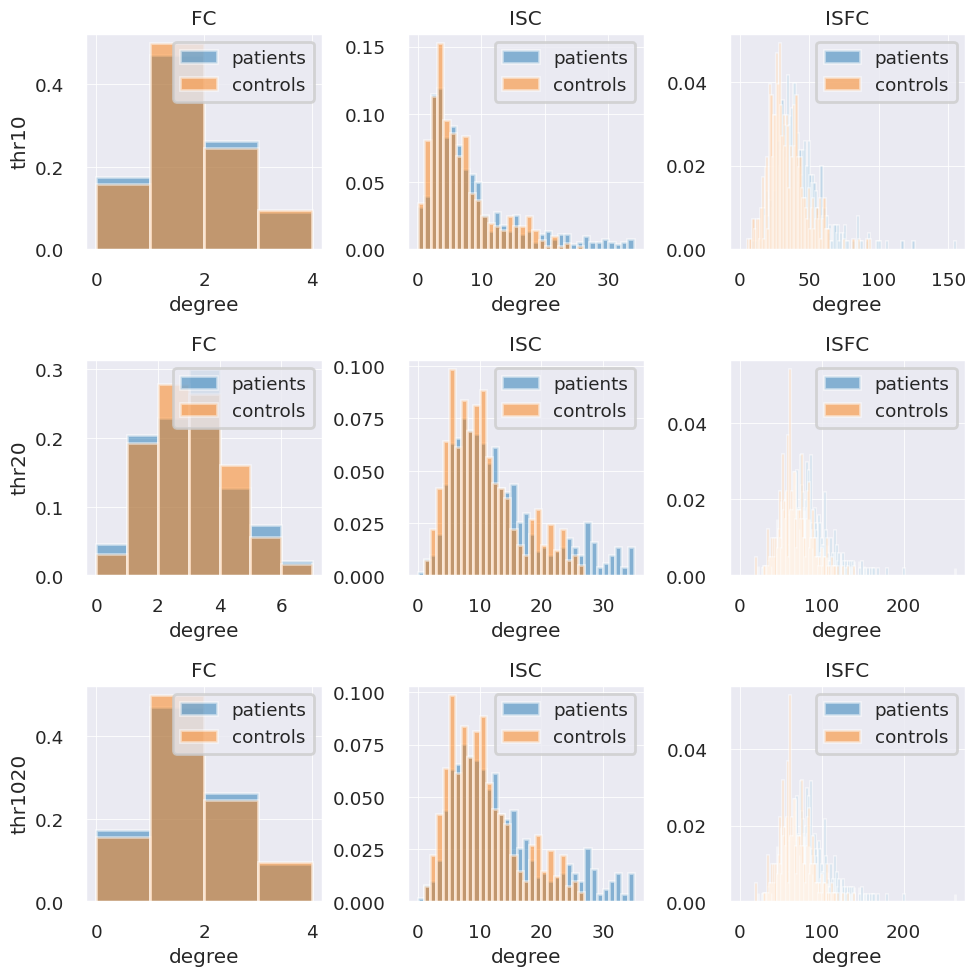

In [89]:
fig, axs = plt.subplots(ncols=3, nrows=3,figsize=(10,10))
labels = ('patients','controls')
for i, net in enumerate(nets):
    p_fc, p_isc, p_fisc = get_deg_distributions(pn.subnet(globals()[net],nodes,patients)) # patient deg distributions
    c_fc, c_isc, c_fisc = get_deg_distributions(pn.subnet(globals()[net],nodes,controls)) # control deg distributions
    
    plot_subj_c(p_fc,c_fc,axs[i,0],labels,'FC')
    plot_subj_c(p_isc,c_isc,axs[i,1],labels,'ISC')
    plot_subj_c(p_fisc,c_fisc,axs[i,2],labels,'ISFC')
    axs[i,0].set_ylabel(net)
fig.tight_layout()
plt.show()

The distributions look about the same for the FC case. However, there are some differences in the ISC and ISFC case. It is good to remember that the sample is unbalanced and this will create potential for more edges being in one group than in another. We can run some non-parametric permutation test on this sample to check if the distributions are truly different. 

In [118]:
r10 = permute(thr10, iter_number=5000)
r10

{}

In [119]:
r20 = permute(thr20, iter_number=5000)
r20

{}

In [120]:
r1020 = permute(thr1020, iter_number=5000)
r1020

{}

After running the permutation tests, we see that there is no difference in the degree distributions and most of the effect we saw most likely due to the sampling process.

## How multiplex-y are the networks?

We binarize our networks using one threshold for interlayer links. However, we know that the ISC weights are commonly a bit larger than the ISFC weights. This may create an imbalance in the networks (e.g., most of the links are between the same node, different layers). Therefore, it is important to understand how 'multiplexy' the network is.

In [96]:
for net in nets:
    isc, isfc = multiplexy(globals()[net])
    print('Network: ', net)
    print('\t ISC links: ',isc)
    print('\t ISFC links: ',isfc)

Network:  thr10
	 ISC links:  13418
	 ISFC links:  70952
Network:  thr20
	 ISC links:  21344
	 ISFC links:  143236
Network:  thr1020
	 ISC links:  21344
	 ISFC links:  142066


In general the thresholding did not produce too 'multiplexy' networks. The network is not dominated by ISC links as expected.

## Bonus: Is there a difference between groups in terms of interlayer or intralayer strength?

Now, let's see if the networks are different in terms of strength

In [107]:
p_fc, p_isc, p_isfc = get_str_distributions(pn.subnet(full,nodes,patients)) 
c_fc, c_isc, c_isfc = get_str_distributions(pn.subnet(full,nodes,controls)) 

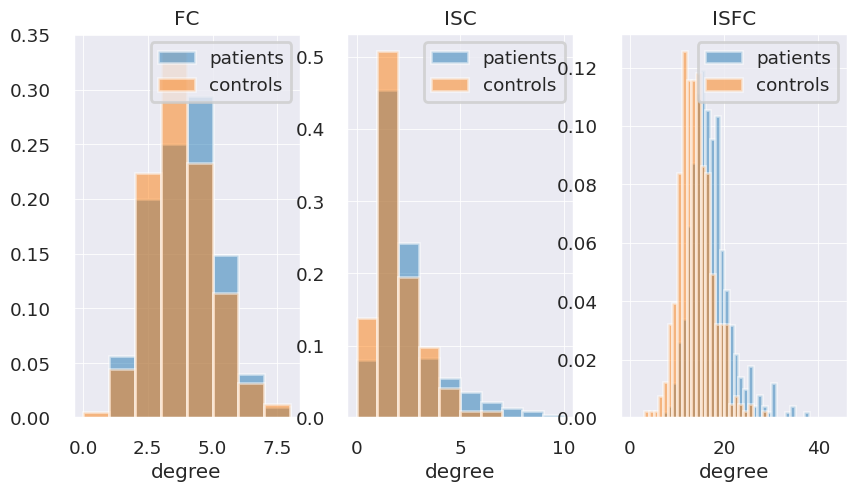

In [114]:
fig, axs = plt.subplots(ncols=3, nrows=1,figsize=(10,5))
labels = ('patients','controls')
plot_subj_c(p_fc,c_fc,axs[0],labels,'FC')
plot_subj_c(p_isc,c_isc,axs[1],labels,'ISC')
plot_subj_c(p_isfc,c_isfc,axs[2],labels,'ISFC')
plt.show()

Here again, we see a difference in the strength for all distributions with a tendency for the patients to be more on the right hand of the plot. Once again, this could be caused by the imbalance in the sample, which has more patients than controls and therefore, provides more opportunities to form more links.

In [122]:
result_str = permute_str(full, iter_number=5000)
result_str

{}